# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.590275,False,-0.278171
1,0.566229,True,5.428592
2,-1.404438,False,0.298664
3,-1.067245,False,-0.878161
4,0.409522,True,3.438348
...,...,...,...
995,2.120289,True,5.751434
996,0.334102,False,-1.126786
997,0.061677,False,0.358249
998,0.598117,True,5.104926


<AxesSubplot:xlabel='v0'>

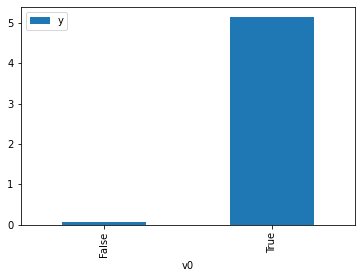

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

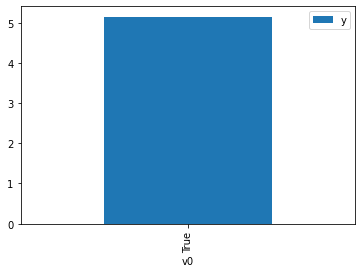

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.720938,False,1.026717,0.261105,3.829876
1,-0.315114,False,0.309982,0.636699,1.570600
2,-2.425106,False,-1.844424,0.978589,1.021879
3,-0.230975,False,-0.875650,0.606118,1.649843
4,-0.178588,False,0.046887,0.586631,1.704649
...,...,...,...,...,...
995,0.595532,False,2.211574,0.300187,3.331259
996,-0.256600,False,-0.557709,0.615533,1.624609
997,1.048891,False,-0.438842,0.175504,5.697876
998,0.568455,False,-1.317740,0.309051,3.235709


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.069022,True,5.954364,0.454944,2.198072
1,-0.624598,True,4.124694,0.261266,3.827523
2,-0.682817,True,5.507109,0.244275,4.093745
3,1.182762,True,6.438738,0.852459,1.173077
4,0.385150,True,3.698663,0.627439,1.593780
...,...,...,...,...,...
995,0.855403,True,4.667625,0.776964,1.287061
996,0.779531,True,3.494618,0.755985,1.322777
997,0.354768,True,5.699484,0.616398,1.622328
998,1.816726,True,5.164837,0.938995,1.064968


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              8001.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        19:00:12   Log-Likelihood:                         -1434.1
No. Observations:                1000   AIC:                                      2872.
Df Residuals:                     998   BIC:                                      2882.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6763      0.037     18.329      0.000       0.604       0.749
x2             5.0178      0.050     99.734      0.000       4.919       5.116
==============================================================================
Omnibus:                        0.705   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.703   Jarque-Bera (JB):                0.576
Skew:                           0.022   Prob(JB):                        0.750
Kurtosis:                       3.109   Cond. No.                         1.88
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""